In [1]:
# Direct Multistep Time Series Forecasting:
#     Direct Day - Predict for specific day of a week. e.g Sat or Tue.

In [4]:
# Direct Day multi-step forecast using Linear Algorithms
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor, Lars, LassoLars
from sklearn.linear_model import RANSACRegressor, PassiveAggressiveRegressor, SGDRegressor

In [5]:
# Split the dataset with daily observation into Train And Test. Use First three years as train and Last year as test.
# After splitting, restructure into window of weekly data.
# i/p: Dataframe Values, o/p: Train and Test array. Each row contains array of daily data for 1 week.
def split_data_train_test(data):
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train , len(train)/7))
    test = np.array(np.split(test , len(test)/7))
    return train, test

In [31]:
# Prepare a list of ML Linear models as dictionary.
def get_models(models=dict()):
    models['LR'] = LinearRegression()
    models['LA'] = Lasso()
    models['RD'] = Ridge()
    models['ET'] = ElasticNet()
    models['HB'] = HuberRegressor()
    models['LRS'] = Lars()
    models['LLRS'] = LassoLars()
    models['RSR'] = RANSACRegressor()
    models['PAG'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)    
    models['SGD'] = SGDRegressor(max_iter=1500, tol=1e-3)
    return models

In [32]:
# Create a Pipeline for a model with Pre-Processing steps.
def make_pipeline(model):
    steps = []
    steps.append(('standardize', StandardScaler()))
    steps.append(('normalize', MinMaxScaler()))
    steps.append(('model', model))  
    pipeline = Pipeline(steps=steps)
    return pipeline               

In [33]:
# Create evaluation matirx using RMSE across each of the forecasted days and overall score.
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate RMSE score of each day for all the weeks available.
    for col in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, col], predicted[:, col])
        rmse = sqrt(mse)
        scores.append(rmse)
        
    # calculate overall RMSE score of all the weeks available.
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row,col] - predicted[row,col])**2
    score = sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores   

In [34]:
# i/p: list of weekly data + index_output_day[0 to 6], o/p: train_x, train_y only for Total Power
def split_train_Xy(history, idx_output):
    X, y = list(), list()
    total_weeks = len(history)
    for week in range(total_weeks-1):
            X.append(history[week][:,0])
            y.append(history[week+1][idx_output,0])   
    return np.array(X), np.array(y)

In [35]:
# The model will use the last row of the training dataset to make the forecast of specific day of next week 
# called Recursive Multistep Forecast.
# Fit a model and make a forecast
# i/p: model, list of weekly data. o/p: Forecast for next 1 week
def predict_model(model, history):
    weekly_predict=[]
    for i in range(7):
        # Call FUNCTION train_test_split
        train_x, train_y = split_train_Xy(history, i)
        
        # Fit the model.
        pipeline = make_pipeline(model)
        pipeline.fit(train_x, train_y) 
        
        # Predict next week 
        X = np.array(train_x[-1,:]).reshape(1,7)
        daily_predict = pipeline.predict(X)[0]
        weekly_predict.append(daily_predict)
    return(weekly_predict)

In [36]:
# Evaluate a single model.
# i/p: Model, Array of train/test and n_input. o/p - Total RMSE and Daily RMSE for 7 days.
def evaluate_model(model, train, test):
    history = [weekly_data for weekly_data in train]
    predictions = []
    for week in range(len(test)):
        # Call FUNCTION predict_model
        weekly_predict = predict_model(model, history)
        predictions.append(weekly_predict)
        history.append(test[week,:])
        
    predictions = np.array(predictions)    
    # Call FUNCTION evaluate_forecast
    score, scores = evaluate_forecasts(test[:,:,0], predictions)
    return score, scores    

In [37]:
# Print Scores
def print_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [38]:
# Load a new file with observations of each day, Parse Dates and make it Index.
# This has been created taking SUM of per second observation from actual i/p
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'],
                     index_col='Datetime')

In [39]:
# Split the dataset into train and test.
train, test = split_data_train_test(dataset.values)

In [40]:
# Create the models.
models = get_models()

LR: [410.927] 463.8, 381.4, 351.9, 430.7, 387.8, 350.4, 488.8
LA: [408.440] 458.4, 378.5, 352.9, 429.5, 388.0, 348.0, 483.5
RD: [403.875] 447.1, 377.9, 347.5, 427.4, 384.1, 343.4, 479.7
ET: [454.263] 471.8, 433.8, 415.8, 477.4, 434.4, 373.8, 551.8
HB: [409.500] 466.8, 380.2, 359.8, 432.4, 387.0, 351.3, 470.9
LRS: [410.927] 463.8, 381.4, 351.9, 430.7, 387.8, 350.4, 488.8
LLRS: [406.490] 453.0, 378.8, 357.3, 428.1, 388.0, 345.0, 476.9
RSR: [493.645] 590.5, 429.0, 386.6, 494.3, 381.9, 454.4, 653.4
PAG: [402.763] 439.7, 380.3, 362.4, 429.0, 385.8, 347.4, 461.1
SGD: [404.201] 453.3, 377.5, 348.0, 427.1, 382.0, 346.8, 475.5


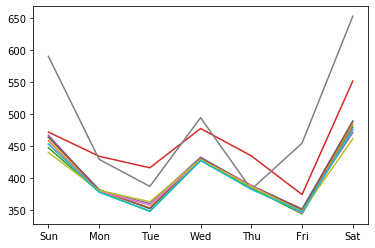

<Figure size 1440x720 with 0 Axes>

In [41]:
# Evaluate each model.
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for name, model in models.items():
    # Call FUNCTION evaluate_model
    score, scores = evaluate_model(model, train, test)
    # Call FUNCTION print_scores
    print_scores(name, score, scores)
    plt.plot(days, scores, label=name)
plt.figure(figsize=(20,10))
plt.show()